In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generic imports
import matplotlib.pyplot as plt
import numpy as np
import glob, datetime, os

from astropy.wcs import WCS
from astropy.io import fits as fits

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import astroscrappy

# Disable some annoying warnings from astropy
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)

# Our sub-modules
from stdpipe import astrometry, photometry, catalogs, cutouts, templates, plots


# Simple catalogue-based pipeline

It shows how to use the functions from the package to construct simple pipeline
that detects transients by comparing the objects with various catalogues.

It assumes that the image is already pre-processed (i.e. dark-subtracted and flat-fielded

Processing 20200306225139-338-RA.fits: filter N, 1056x1024
Done masking cosmics: 95 pixels masked
60 objects found
7 objects not matched with reference catalogue
1 of them are unflagged
1 remains after matching with PanSTARRS DR1
1 remains after matching with USNO-B1
1 remains after matching with GSC 2.2
1 remains after matching with SkyBot
1 remains after matching with NED
1 candidate(s) remaining
id 21: 13.963 mag at 198.556 11.2701


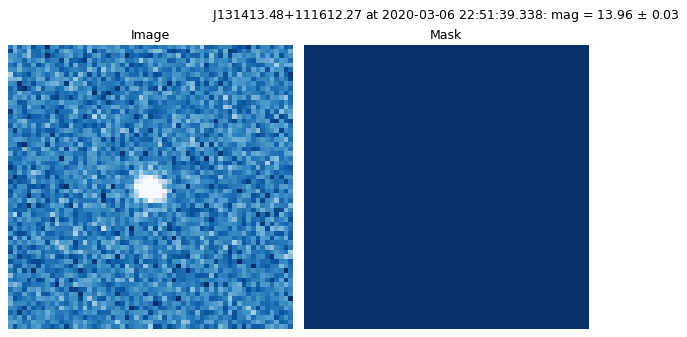

In [2]:
# FRAM pre-processed image containing GRB200306C, white light
filename = '../tests/20200306225139-338-RA.fits'

header = fits.getheader(filename)
image = fits.getdata(filename).astype(np.double)

fname = header['FILTER'].strip()
time = Time(header['DATE-OBS'])

print('Processing %s: filter %s, %dx%d' % (os.path.split(filename)[1], fname, image.shape[1], image.shape[0]))

# Create mask of bad pixels
mask = image > 50000 # Rough saturation level

# Cosmics
cmask, cimage = astroscrappy.detect_cosmics(image, mask, verbose=False)
print('Done masking cosmics: %d pixels masked' % np.sum(cmask))

# Extract objects
obj = photometry.get_objects_sextractor(image, mask=mask|cmask, r0=2, aper=5.0)
obj['id'] = np.arange(len(obj)) # Sort of unique identifier for the objects
obj['time'] = time
print(len(obj), 'objects found')

# TODO: perform proper accurate photometry here to improve the measurements

# Initial WCS from FITS header
wcs = WCS(header)

obj['ra'],obj['dec'] = wcs.all_pix2world(obj['x'], obj['y'], 0)

ra0,dec0,sr0 = astrometry.get_frame_center(wcs=wcs, width=image.shape[1], height=image.shape[0])
pixscale = np.hypot(wcs.pixel_scale_matrix[0,0], wcs.pixel_scale_matrix[0,1])

# Get reference catalogue for astrometric/photometric match, so not too deep
cat = catalogs.get_cat_vizier(ra0, dec0, sr0, 'ps1', filters={'rmag':'<17'})

# Initial loose match for refining the WCS
for iter in range(3):
    # Simple positional matching
    # wcs = refine_wcs(obj, cat, order=2, sr=20.0*pixscale, update=True)
    # Matching involving photometric information
    m = photometry.match(obj['ra'], obj['dec'], obj['mag'], np.hypot(obj['magerr'], 0.02), obj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['R'], sr=20.0*pixscale)
    if np.sum(m['idx']) < 10:
        print('Too few good matches, cannot refine WCS')
        break
        
    # Fit WCS with SIP polynomial, second order
    wcs = astrometry.refine_wcs(obj[m['oidx']][m['idx']], cat[m['cidx']][m['idx']], order=2, match=False)
    
    # Update sky coordinates of detected objects
    obj['ra'],obj['dec'] = wcs.all_pix2world(obj['x'], obj['y'], 0)

# Update WCS info in the header
astrometry.clear_wcs(header, remove_comments=True, remove_underscored=True, remove_history=True)
header.update(wcs.to_header(relax=True))

# Positional matching radius, assuming FWHM is more or less constant over the frame
sr = np.median(obj['fwhm'])/2 * pixscale
sr = max(1/3600, sr)

# Photometric calibration
m = photometry.match(obj['ra'], obj['dec'], obj['mag'], np.hypot(obj['magerr'], 0.02), obj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['R'], sr=sr, cat_color=cat['B']-cat['V'])
obj['mag_calib'] = obj['mag'] + m['zero_fn'](obj['x'], obj['y'])

# Secondary loose match for exclusion of catalogue objects
mc = photometry.match(obj['ra'], obj['dec'], obj['mag'], np.hypot(obj['magerr'], 0.02), obj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['R'], sr=2.0*sr)

# Initial candidates - the objects not matched with the catalogue
cand_idx = ~np.in1d(np.arange(len(obj['x'])), mc['oidx'])
print(np.sum(cand_idx), 'objects not matched with reference catalogue')

# Filter out flagged objects (saturated, cosmics, blends, etc)
cand_idx &= obj['flags'] == 0
print(np.sum(cand_idx), 'of them are unflagged')

# Cross-match with photometric catalogues using XMatch
for catname in ['ps1', 'usnob1', 'gsc']:
    if not np.any(cand_idx):
        break

    xcat = catalogs.xmatch_objects(obj[cand_idx], catname, sr)
    if xcat and len(xcat):
        cand_idx &= ~np.in1d(obj['id'], xcat['id'])

    print(np.sum(cand_idx), 'remains after matching with', catalogs.catalogs.get(catname)['name'])

# Check SkyBot for solar system objects
if np.any(cand_idx):
    xcat = catalogs.xmatch_skybot(obj[cand_idx], time=time)
    if xcat and len(xcat):
        cand_idx &= ~np.in1d(obj['id'], xcat['id'])
    print(np.sum(cand_idx), 'remains after matching with SkyBot')

# Check NED for galaxies
if np.any(cand_idx):
    xcat = catalogs.xmatch_ned(obj[cand_idx], 2*sr)
    if xcat and len(xcat):
        cand_idx &= ~np.in1d(obj['id'], xcat['id'])
    print(np.sum(cand_idx), 'remains after matching with NED')

print(np.sum(cand_idx), 'candidate(s) remaining')

# Display cutouts
bg = photometry.get_background(image, mask=mask)

for cand in obj[cand_idx]:
    print('id %d: %g mag at %g %g' % (cand['id'], cand['mag_calib'], cand['ra'], cand['dec']))
    cutout = cutouts.get_cutout(image, cand, 30, mask=mask, bg=bg, header=header, filename=filename)

    # We do not have difference image or template, so it will only display original one and mask
    plots.plot_cutout(cutout)
    plt.show()

# Plot photometric solution

<AxesSubplot:title={'center':'color term = -0.04'}, xlabel='Catalogue color', ylabel='Model - Instrumental'>

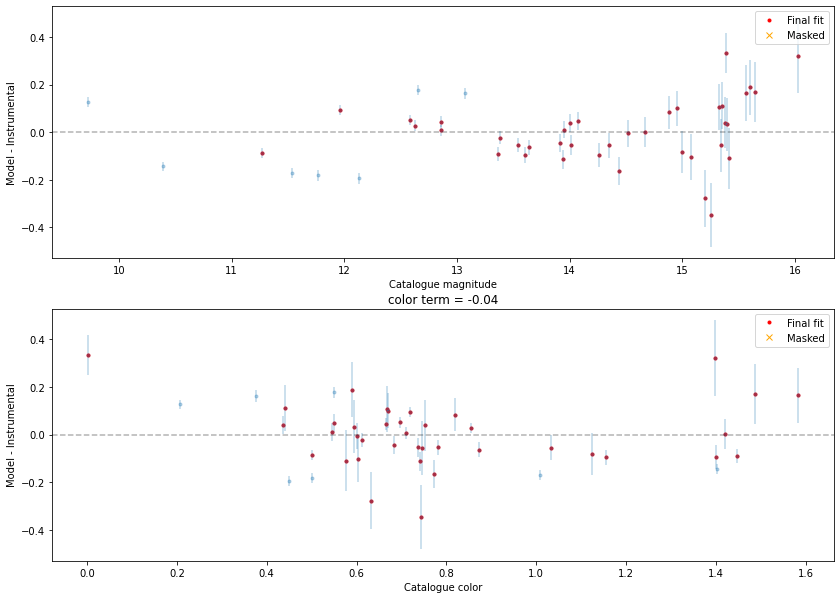

In [3]:
plt.subplot(211)
plots.plot_photometric_match(m)

plt.subplot(212)
plots.plot_photometric_match(m, mode='color')

Text(0.5, 1.0, 'All detected objects')

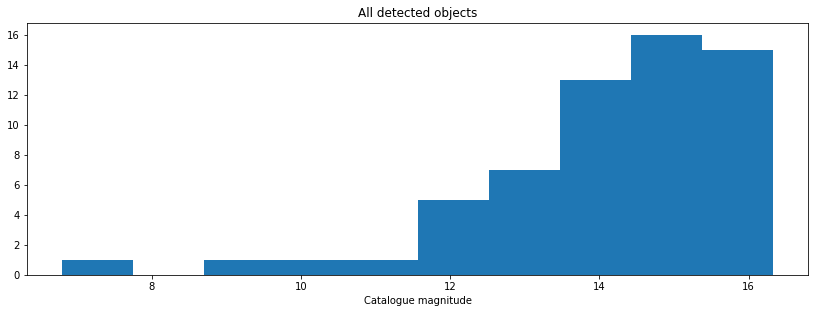

In [4]:
plt.subplot(211)
plt.hist(obj['mag_calib']);
plt.xlabel('Catalogue magnitude')
plt.title('All detected objects')

# Original image

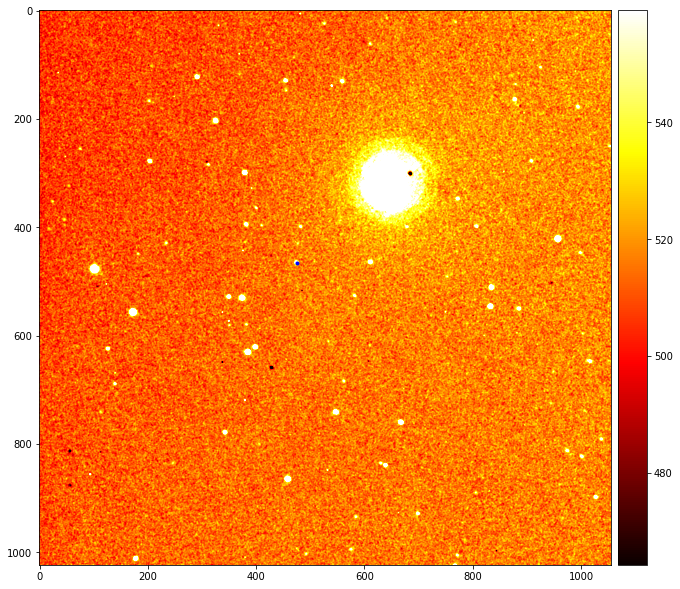

In [5]:
plots.imshow(image, cmap='hot')
plt.plot(obj['x'][cand_idx], obj['y'][cand_idx], 'b.')

# Template image from PanSTARRS

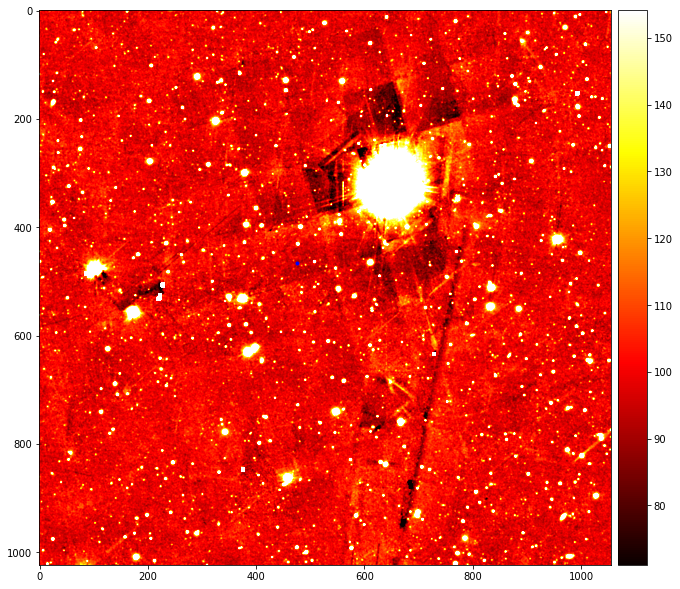

In [6]:
# We may get rough template from fits2hips service already pre-projected to our WCS 
tmpl,tmplhdr = templates.get_hips_image('PanSTARRS/DR1/r', wcs=wcs, width=image.shape[1], height=image.shape[0])
plots.imshow(tmpl, cmap='hot')
plt.plot(obj['x'][cand_idx], obj['y'][cand_idx], 'b.')

# Subtract the images!

In [7]:
# TODO: perform the subtraction